(10, 5) (2, 5)


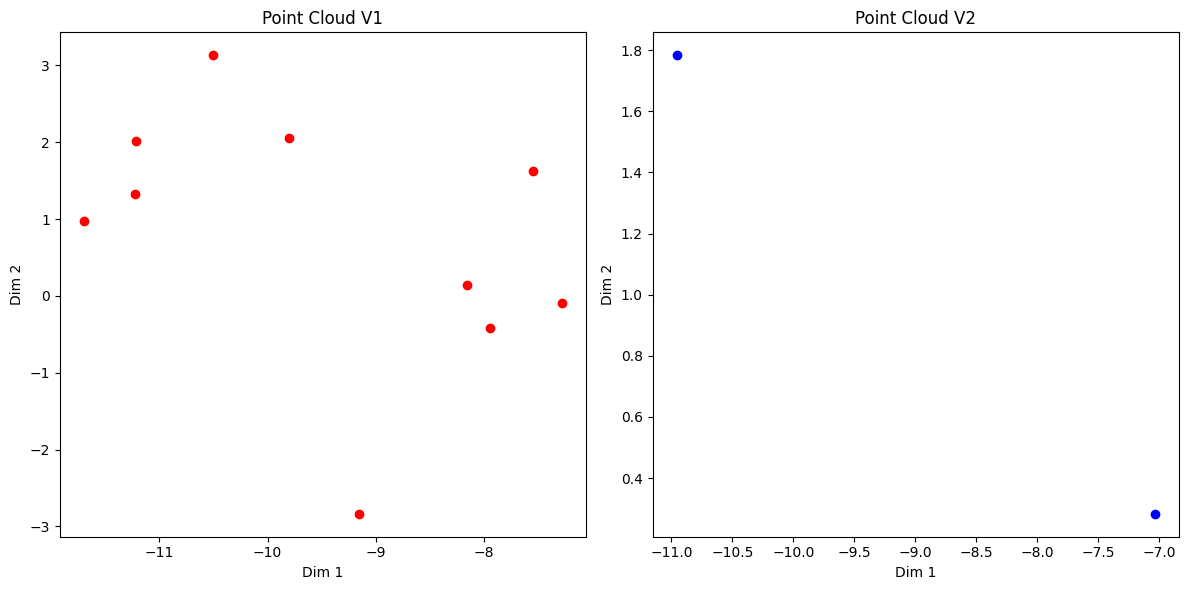

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from myotc.utils import approx_stat_dist, exact_otc, fgw_dist, computeot_lp, eval_alignment

# Helper function to generate point cloud
def get_pointcloud(mean_sigma, block_size, n_blocks, dim):
    point_sigma = 1
    means = np.random.normal(0, mean_sigma, (n_blocks, dim))
    points = np.zeros((block_size * n_blocks, dim))
    for c in range(n_blocks):
        for dim_idx in range(dim):
            points[c * block_size: (c + 1) * block_size, dim_idx] = np.random.normal(means[c, dim_idx], point_sigma, block_size)
    return points, means

# Params
block_size = 5
n_blocks = 2
n = block_size * n_blocks
dim = 5
mean_sigma = 5  # Example value

# Generate point clouds V1 and V2
V1, V2 = get_pointcloud(mean_sigma, block_size, n_blocks, dim)

# Generate random matrix A2
A2 = np.random.randint(1, 11, (n_blocks, n_blocks))

# Generate matrix A1
A1 = np.zeros((n, n))
for i in range(n_blocks):
    for j in range(n_blocks):
        for k in range(block_size):
            rv = np.random.rand(block_size)
            rv = rv * A2[i, j] / np.sum(rv) / block_size
            A1[i * block_size + k, j * block_size: (j + 1) * block_size] = rv

print(V1.shape, V2.shape)
# print(A1.shape, A2.shape)

P1 = A1 / np.sum(A1, axis=1)[:, np.newaxis]
P2 = A2 / np.sum(A2, axis=1)[:, np.newaxis]

stat_dist1 = approx_stat_dist(P1, 100)
stat_dist2 = approx_stat_dist(P2, 100)

stat_dist3 = np.ones((n, 1)) / n

stat_dist4 = np.ones((n_blocks, 1)) / n_blocks

c = np.zeros((n, n_blocks))

for i in range(n):
    for j in range(n_blocks):
        c[i, j] = np.sum((V1[i, :] - V2[j, :]) ** 2)

_, otc_edge_alignment, otc_alignment = exact_otc(P1, P2, c)
_, fgw_alignment = fgw_dist(c, A1, A2, stat_dist3, stat_dist4, 1, 0.5)
otsd_alignment, _ = computeot_lp(c.T, stat_dist1, stat_dist2.T)
otsd_alignment = otsd_alignment.reshape(n_blocks, n).T

aligned_mass_otc = eval_alignment(otc_alignment, block_size, n_blocks)
aligned_mass_fgw = eval_alignment(fgw_alignment, block_size, n_blocks)
aligned_mass_otsd = eval_alignment(otsd_alignment, block_size, n_blocks)


# Plot V1 and V2 as scatter plots for visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(V1[:, 0], V1[:, 1], c='r', label='V1')
plt.title('Point Cloud V1')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

plt.subplot(1, 2, 2)
plt.scatter(V2[:, 0], V2[:, 1], c='b', label='V2')
plt.title('Point Cloud V2')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

plt.tight_layout()
plt.show()


In [60]:
A2

array([[ 7,  6,  1,  4],
       [10,  1, 10,  1],
       [ 7, 10,  8,  3],
       [ 9,  2,  9,  7]])

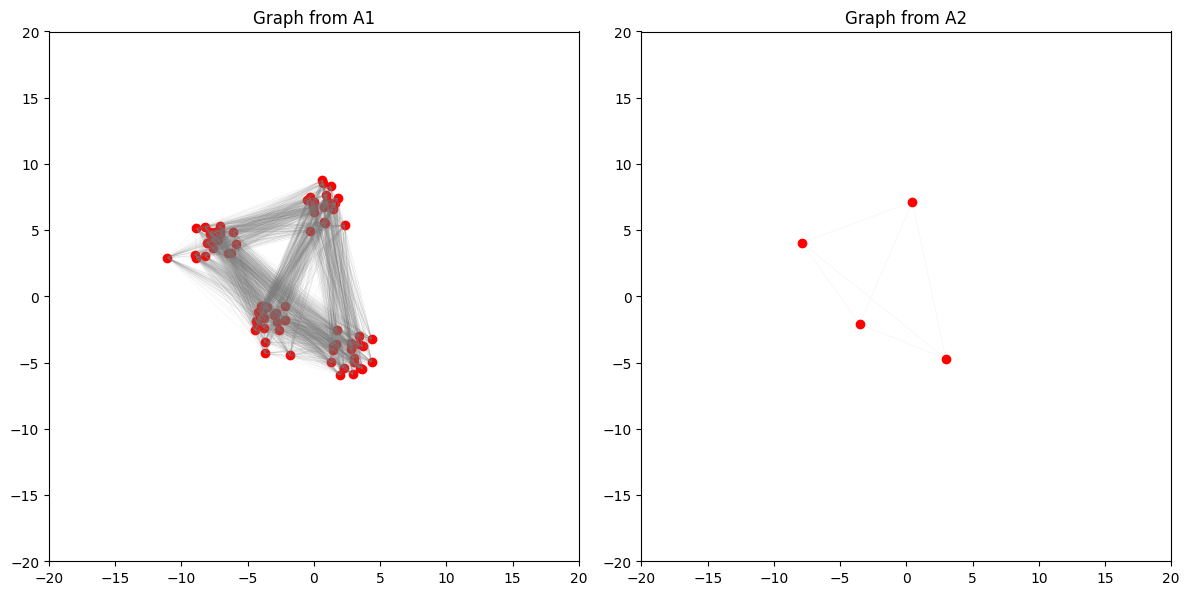

In [59]:
# Helper function to plot graph based on adjacency matrix and coordinates
def plot_graph(A, coords, ax, title):
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Avoid double-counting edges
            if A[i, j] > 0:
                ax.plot([coords[i, 0], coords[j, 0]], [coords[i, 1], coords[j, 1]], '-', linewidth=0.2, alpha=0.2, color='gray')
                pass

    ax.scatter(coords[:, 0], coords[:, 1], c='r')
    ax.set_aspect('equal')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_title(title)

# Create a figure and axis for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the graphs
plot_graph(A1, V1[:, :2], axes[0], 'Graph from A1')
plot_graph(A2, V2[:n_blocks, :2], axes[1], 'Graph from A2')  # Only use the first n_blocks rows of V2 for visualization

plt.tight_layout()
plt.show()
